# Natural Language Processing for Loan Risk

1. **[The story so far](#The-story-so-far)**
2. **[Exploratory data analysis](#Exploratory-data-analysis)**
3. **[Imputing missing values](#Imputing-missing-values)**
4. **[Optimizing data types](#Optimizing-data-types)**
5. **[Creating document vectors](#Creating-document-vectors)**
6. **[Building the pipeline](#Building-the-pipeline)**
7. **[Evaluating the model](#Evaluating-the-model)**
8. **[Next steps](#Next-steps)**

## The story so far

A couple months ago, I [built a neural network regression model](https://www.kaggle.com/tywmick/building-a-neural-network-to-predict-loan-risk) to predict loan risk, training it with a [public dataset](https://www.kaggle.com/wordsforthewise/lending-club) from [LendingClub](https://www.lendingclub.com/). Then I built a [public API](https://tywmick.pythonanywhere.com/) with [Flask](https://flask.palletsprojects.com/en/1.1.x/) to serve the model's predictions.

Then a few weeks ago, I decided to put my model to the test and found out that my model can pick grade A loans [better than LendingClub](https://www.kaggle.com/tywmick/can-i-grade-loans-better-than-lendingclub)!

But I'm not done. Now that I've learned the fundamentals of natural language processing (I highly recommend [Kaggle's course](https://www.kaggle.com/learn/natural-language-processing) on the subject), I'm going to see if I can eke out a bit more predictive power using a couple of freeform text fields in the dataset: `title` and `desc` (description).

In [1]:
import joblib

prev_notebook_folder = "../input/building-a-neural-network-to-predict-loan-risk/"
loans = joblib.load(prev_notebook_folder + "loans_for_nlp.joblib")
num_loans = loans.shape[0]
print(f"This dataset includes {num_loans:,} loans.")

This dataset includes 1,110,171 loans.


In [2]:
loans.head()

,loan_amnt,term,emp_length,home_ownership,annual_inc,purpose,dti,delinq_2yrs,cr_hist_age_mths,fico_range_low,...,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,fraction_recovered,issue_d,title,desc
0,3600.0,36 months,10+ years,MORTGAGE,55000.0,debt_consolidation,5.91,0.0,148,675.0,...,0.0,0.0,178050.0,7746.0,2400.0,13734.0,1.0,Dec-2015,Debt consolidation,NaN
1,24700.0,36 months,10+ years,MORTGAGE,65000.0,small_business,16.06,1.0,192,715.0,...,0.0,0.0,314017.0,39475.0,79300.0,24667.0,1.0,Dec-2015,Business,NaN
2,20000.0,60 months,10+ years,MORTGAGE,63000.0,home_improvement,10.78,0.0,184,695.0,...,0.0,0.0,218418.0,18696.0,6200.0,14877.0,1.0,Dec-2015,NaN,NaN
4,10400.0,60 months,3 years,MORTGAGE,104433.0,major_purchase,25.37,1.0,210,695.0,...,0.0,0.0,439570.0,95768.0,20300.0,88097.0,1.0,Dec-2015,Major purchase,NaN
5,11950.0,36 months,4 years,RENT,34000.0,debt_consolidation,10.20,0.0,338,690.0,...,0.0,0.0,16900.0,12798.0,9400.0,4000.0,1.0,Dec-2015,Debt consolidation,NaN


## Exploratory data analysis

There isn't _too_ much exploratory data analysis left to do after how thoroughly I [cleaned the data](https://www.kaggle.com/tywmick/building-a-neural-network-to-predict-loan-risk#Data-cleaning) in my first notebook, but I do have a few quick questions about the `title` and `desc` fields I'd like to answer before I move on.

- How many loans use each field?
- Have these fields always been included in the loan application?
- What is the typical length of each field (in number of words)?

In [3]:
nlp_cols = ["title", "desc"]

loans[nlp_cols].describe()

,title,desc
count,1097288,71967
unique,35863,70927
top,Debt consolidation,
freq,573992,23


If the most frequent `desc` value is empty (or maybe just whitespace), perhaps I need to convert all empty or whitespace-only values to `NaN` before continuing.

In [4]:
import re
import numpy as np

for col in nlp_cols:
    replace_empties = lambda x: x if re.search("\S", x) else np.NaN
    loans[col] = loans[col].map(replace_empties, na_action="ignore")

description = loans[nlp_cols].describe()
description

,title,desc
count,1097288,71943
unique,35863,70925
top,Debt consolidation,Borrower added on 03/17/14 > Debt consolidat...
freq,573992,9


Thankfully that didn't remove too many values, but this "Borrower added on [date]" deal worries me now. I'll deal with that a little later.

In [5]:
for col in nlp_cols:
    percentage = int(description.at["count", col] / num_loans * 100)
    print(f"`{col}` is used in {percentage}% of loans in the dataset.")

percentage = int(description.at["freq", "title"] / num_loans * 100)
print(f'The title "Debt consolidation" is used in {percentage}% of loans.')

`title` is used in 98% of loans in the dataset.
`desc` is used in 6% of loans in the dataset.
The title "Debt consolidation" is used in 51% of loans.


These fields may not be as useful as I had previously thought. Even though there are 35,860 unique titles used across the dataset, 51% of them just use "Debt consolidation". Maybe the titles are more descriptive in the other 49%?

And the `desc` field is only used with 6% of loans.

Now to check and see when these fields were introduced.

In [6]:
# `issue_d` is just the month and year the loan was issued, by the way.
loans["issue_d"] = loans["issue_d"].astype("datetime64[ns]")

print("Total date range:")
print(loans["issue_d"].agg(["min", "max"]))
print("\n`title` date range:")
print(loans[["title", "issue_d"]].dropna(axis="index")["issue_d"].agg(["min", "max"]))
print("\n`desc` date range:")
print(loans[["desc", "issue_d"]].dropna(axis="index")["issue_d"].agg(["min", "max"]))

Total date range:
min   2012-08-01
max   2018-12-01
Name: issue_d, dtype: datetime64[ns]

`title` date range:
min   2012-08-01
max   2018-12-01
Name: issue_d, dtype: datetime64[ns]

`desc` date range:
min   2012-08-01
max   2016-07-01
Name: issue_d, dtype: datetime64[ns]


Neither of these fields were introduced late, but they may have stopped using the `desc` field for the last two years of the database.

Now I'll take a closer look at values in these fields.

In [7]:
import pandas as pd

with pd.option_context("display.min_rows", 50):
    print(loans["title"].value_counts())

Debt consolidation                       573992
Credit card refinancing                  214423
Home improvement                          64028
Other                                     56166
Major purchase                            20734
Medical expenses                          11454
Debt Consolidation                        10638
Business                                  10142
Car financing                              9660
Moving and relocation                      6806
Vacation                                   6707
Home buying                                5097
Consolidation                              4069
debt consolidation                         3310
Credit Card Consolidation                  1607
consolidation                              1538
Debt Consolidation Loan                    1265
Consolidation Loan                         1260
Personal Loan                              1040
Credit Card Refinance                      1020
Home Improvement                        

Interesting. It seems like there's plenty of variety in loan titles in the other 49%. A lot of them seem to directly correspond to the `purpose` categorical field, but not so many as to make this field useless, I think.

Side note: I discovered at one point when perusing this column that someone entered the [Konami Code](https://en.wikipedia.org/wiki/Konami_Code) as the title of their loan application, and their inclusion in this dataset means that the code apparently worked for them—they got the loan.

In [8]:
loans[loans["title"] == "up up down down left right left right ba"][
    ["loan_amnt", "title", "issue_d"]
]

,loan_amnt,title,issue_d
1856340,12000.0,up up down down left right left right ba,2013-04-01


In [9]:
loans["desc"].value_counts()

  Borrower added on 03/17/14 > Debt consolidation<br>                                                                                                                                                                                                                                        9
  Borrower added on 01/15/14 > Debt consolidation<br>                                                                                                                                                                                                                                        7
  Borrower added on 02/19/14 > Debt consolidation<br>                                                                                                                                                                                                                                        7
  Borrower added on 03/10/14 > Debt consolidation<br>                                                                                      

Do all these descriptions start with "Borrower added on [date]"?

In [10]:
pattern = "^\s*Borrower added on \d\d/\d\d/\d\d > "
prefix_count = (
    loans["desc"]
    .map(lambda x: True if re.search(pattern, x, re.I) else None, na_action="ignore")
    .count()
)
print(
    f"{prefix_count:,} loan descriptions begin with that pattern.",
    f"({description.loc['count', 'desc'] - prefix_count:,} do not.)",
)

71,858 loan descriptions begin with that pattern. (85 do not.)


Well now I need to check those other 85.

In [11]:
other_desc_map = loans["desc"].map(
    lambda x: False if pd.isna(x) or re.search(pattern, x, re.I) else True
)
other_descs = loans["desc"][other_desc_map]
other_descs.value_counts()

Debt Consolidation                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

It looks like the borrower may be able to add information to the description at different points in time. I should check and see if any of those dates come after the actual issue date of the loan.

In [12]:
from datetime import datetime, date

for row in loans[["desc", "issue_d"]].itertuples():
    if not pd.isna(row.desc):
        month_after_issue = date(
            day=row.issue_d.day,
            month=row.issue_d.month % 12 + 1,
            year=row.issue_d.year + row.issue_d.month // 12,
        )

        date_strings = re.findall("\d\d/\d\d/\d\d", row.desc)
        dates = []
        for string in date_strings:
            try:
                dates.append(datetime.strptime(string, "%m/%d/%y").date())
            except:
                continue

        for d in dates:
            if d >= month_after_issue:
                print(f"{row.issue_d} – {row.desc}")
                break

2014-01-01 00:00:00 –   Borrower added on 01/08/14 > I am tired of making monthly payments and getting nowhere.  With your help, except for my mortgage, I intend to be completely debt free by 12/31/2016.<br>
2014-01-01 00:00:00 –   Borrower added on 01/08/14 > We have been engaged for  2 1/2yrs and wanted to bring out blended family together as one. We are set to get married on 03/22/14 and we are paying for it on our own. We saved the majority of the budget unfortunately there were a few unexpected cost that we still need help with.<br>
2014-01-01 00:00:00 –   Borrower added on 01/06/14 > I am getting married 04/05/2014 and I want to have a cushion for expenses just in case.<br>
2014-01-01 00:00:00 – BR called in to push payment date to 09/19/14 because of not having the exact amount of funds in their bank account.  Payment was processing. Was able to cancel. It is within grace period. 
2014-01-01 00:00:00 –   Borrower added on 01/01/14 > This loan is to consolidate my credit cards de

Good, all of the dates that come after the month the loan is issued only come up because the borrower is talking about a future event.

Now to clean these `desc` values up a bit I'm going to remove the `Borrower added on [date] >`s and the `<br>`s, since those don't add value to the description content.

In [13]:
def clean_desc(desc):
    if pd.isna(desc):
        return desc
    else:
        return re.sub(
            "\s*Borrower added on \d\d/\d\d/\d\d > |<br>", lambda x: " ", desc
        ).strip()


loans["desc"] = loans["desc"].map(clean_desc)

## Imputing missing values

Since only 2% of loans in this set are missing a title, and since most titles simply copy the loan's `purpose`, I'm going to impute missing titles with their loan's purpose.

In [14]:
loans["title"].fillna(
    loans["purpose"].map(lambda x: x.replace("_", " ").capitalize()), inplace=True
)

Since only 6% of loans _use_ a description, I'll just impute missing descriptions with an empty string. I'm going to wait and include that as a pipeline step a little later, though.

## Optimizing data types

I'd really love to get right to the fun part, converting these text fields into document vectors, but I ran into a problem the first several times I tried doing so. Manually adding two sets of 300-dimensional vectors to this 1,110,171-row DataFrame caused its size in memory to skyrocket, exhausting the 16GB Kaggle gives me.

My first attempt to fix this was optimizing my data types, which still didn't solve the problem on its own, but it's a worthwhile step to take anyway.

After removing the `issue_d` column, which is no longer needed, the dataset contains five types of data: float, integer, ordinal, (unordered) categorical, and text.

In [15]:
from pandas.api.types import CategoricalDtype


loans = loans.drop(columns=["issue_d"])

float_cols = ["annual_inc", "dti", "inv_mths_since_last_delinq",
    "inv_mths_since_last_record", "revol_util", "inv_mths_since_last_major_derog",
    "annual_inc_joint", "dti_joint", "bc_util", "inv_mo_sin_rcnt_rev_tl_op",
    "inv_mo_sin_rcnt_tl", "inv_mths_since_recent_bc", "inv_mths_since_recent_bc_dlq",
    "inv_mths_since_recent_inq", "inv_mths_since_recent_revol_delinq", "pct_tl_nvr_dlq",
    "percent_bc_gt_75", "fraction_recovered"]
int_cols = ["loan_amnt", "delinq_2yrs", "cr_hist_age_mths", "fico_range_low",
    "fico_range_high", "inq_last_6mths", "open_acc", "pub_rec", "revol_bal",
    "total_acc", "collections_12_mths_ex_med", "acc_now_delinq", "tot_coll_amt",
    "tot_cur_bal", "total_rev_hi_lim", "acc_open_past_24mths", "avg_cur_bal",
    "bc_open_to_buy", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mort_acc", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl", "num_op_rev_tl",
    "num_rev_accts", "num_rev_tl_bal_gt_0", "num_sats", "num_tl_120dpd_2m",
    "num_tl_30dpd", "num_tl_90g_dpd_24m", "num_tl_op_past_12m", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit"]
ordinal_cols = ["emp_length"]
category_cols = ["term", "home_ownership", "purpose", "application_type"]
text_cols = nlp_cols

size_metrics = pd.DataFrame(
    {
        "previous_dtype": loans.dtypes,
        "previous_size": loans.memory_usage(index=False, deep=True),
    }
)
previous_size = loans.memory_usage(deep=True).sum()


for col_name in float_cols:
    loans[col_name] = pd.to_numeric(loans[col_name], downcast="float")

for col_name in int_cols:
    loans[col_name] = pd.to_numeric(loans[col_name], downcast="unsigned")

emp_length_categories = ["< 1 year", "1 year", "2 years", "3 years", "4 years",
    "5 years", "6 years", "7 years", "8 years", "9 years", "10+ years"]
emp_length_type = CategoricalDtype(categories=emp_length_categories, ordered=True)
loans["emp_length"] = loans["emp_length"].astype(emp_length_type)

for col_name in category_cols:
    loans[col_name] = loans[col_name].astype("category")


current_size = loans.memory_usage(deep=True).sum()
reduction = (previous_size - current_size) / previous_size
print(f"Reduced DataFrame size in memory by {int(reduction * 100)}%.")

size_metrics["current_dtype"] = loans.dtypes
size_metrics["current_size"] = loans.memory_usage(index=False, deep=True)
pd.options.display.max_rows = 100
size_metrics

Reduced DataFrame size in memory by 69%.


,previous_dtype,previous_size,current_dtype,current_size
loan_amnt,float64,8881368,uint16,2220342
term,object,73271286,category,1110383
emp_length,object,71853397,category,1111197
home_ownership,object,69841784,category,1110700
annual_inc,float64,8881368,float32,4440684
purpose,object,79927721,category,1111750
dti,float64,8881368,float32,4440684
delinq_2yrs,float64,8881368,uint8,1110171
cr_hist_age_mths,int64,8881368,uint16,2220342
fico_range_low,float64,8881368,uint16,2220342


## Creating document vectors

_Now_ the fun part. Wrapping my [spaCy](https://spacy.io/) document vector function in a scikit-learn [`FunctionTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html) turned out to be the secret that kept this process within memory limits. Scikit-learn must just be way better optimized than whatever manual process I was using (go figure).

In [16]:
import spacy
from sklearn.preprocessing import FunctionTransformer


def get_doc_vectors(X):
    n_cols = X.shape[1]
    nlp = spacy.load("en_core_web_lg", disable=["tagger", "parser", "ner"])
    
    result = []
    for row in X:
        result_row = []
        for i in range(n_cols):
            result_row.append(nlp(row[i]).vector)
            
        result.append(np.concatenate(result_row))
        
    return np.array(result)


vectorizer = FunctionTransformer(get_doc_vectors)

## Building the pipeline

First, the transformer. I'll use scikit-learn's [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) to apply different transformations to different kinds of data.

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from pathlib import Path


def generate_cat_encoder(col_name):
    categories = list(loans[col_name].cat.categories)
    if loans[col_name].cat.ordered:
        return (
            col_name,
            OrdinalEncoder(categories=[categories], dtype=np.uint8),
            [col_name],
        )
    else:
        return (
            col_name,
            OneHotEncoder(categories=[categories], drop="if_binary", dtype=np.bool_),
            [col_name],
        )


Path("../tmp/transformer_cache").mkdir(parents=True, exist_ok=True)
transformer = ColumnTransformer(
    [
        (
            "nlp_cols",
            Pipeline(
                [
                    (
                        "nlp_imputer",
                        SimpleImputer(strategy="constant", fill_value=""),
                    ),
                    ("nlp_vectorizer", vectorizer),
                    ("nlp_scaler", StandardScaler(with_mean=False)),
                ],
                verbose=True,
            ),
            make_column_selector("^(title|desc)$"),
        ),
    ]
    + [generate_cat_encoder(col_name) for col_name in ordinal_cols + category_cols],
    remainder=StandardScaler(),
    verbose=True,
)

This model itself will be identical to my [previous model](https://www.kaggle.com/tywmick/building-a-neural-network-to-predict-loan-risk#Building-the-neural-networks), but I'll use Keras callbacks and a [tqdm](https://github.com/tqdm/tqdm) progress bar to make the training logs much more concise.

In [18]:
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tqdm import tqdm

np.random.seed(0)
tf.random.set_seed(1)


class ProgressBar(tf.keras.callbacks.Callback):
    def __init__(self, epochs=100):
        self.epochs = epochs
    
    def on_train_begin(self, logs=None):
        self.progress_bar = tqdm(desc="Training model", total=self.epochs, unit="epoch")

    def on_epoch_end(self, epoch, logs=None):
        self.progress_bar.update()

    def on_train_end(self, logs=None):
        self.progress_bar.close()


class FinalMetrics(tf.keras.callbacks.Callback):
    def on_train_end(self, logs=None):
        metrics_msg = "Final metrics:"
        for metric, value in logs.items():
            metrics_msg += f" {metric}: {value:.5f} -"
        metrics_msg = metrics_msg[:-2]
        print(metrics_msg)


def run_pipeline(X, y, transformer, validate=True):
    X_train, X_val, y_train, y_val = (
        train_test_split(X, y, test_size=0.2, random_state=2)
        if validate
        else (X, None, y, None)
    )

    X_train_t = transformer.fit_transform(X_train)
    X_val_t = transformer.transform(X_val) if validate else None

    model = Sequential()
    model.add(Input((X_train_t.shape[1],)))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mean_squared_logarithmic_error")

    history = model.fit(
        X_train_t,
        y_train,
        validation_data=(X_val_t, y_val) if validate else None,
        batch_size=128,
        epochs=100,
        verbose=0,
        callbacks=[ProgressBar(), FinalMetrics()],
    )
    
    return history.history, model, transformer

## Evaluating the model

In [19]:
import dill

history_1, _, _ = run_pipeline(
    loans.drop(columns="fraction_recovered").copy(),
    loans["fraction_recovered"],
    transformer,
)

Path("save_points").mkdir(exist_ok=True)
dill.dump_session("save_points/model_1.pkl")

/opt/conda/lib/python3.7/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


[Pipeline] ....... (step 1 of 3) Processing nlp_imputer, total=   0.4s
[Pipeline] .... (step 2 of 3) Processing nlp_vectorizer, total= 1.2min
[Pipeline] ........ (step 3 of 3) Processing nlp_scaler, total=   8.6s
[ColumnTransformer] ...... (1 of 7) Processing nlp_cols, total= 1.3min
[ColumnTransformer] .... (2 of 7) Processing emp_length, total=   0.2s
[ColumnTransformer] .......... (3 of 7) Processing term, total=   0.3s
[ColumnTransformer]  (4 of 7) Processing home_ownership, total=   0.3s
[ColumnTransformer] ....... (5 of 7) Processing purpose, total=   0.3s
[ColumnTransformer]  (6 of 7) Processing application_type, total=   0.3s
[ColumnTransformer] ..... (7 of 7) Processing remainder, total=   1.3s


Training model: 100%|██████████| 100/100 [23:41<00:00, 14.22s/epoch]


Final metrics: loss: 0.02365 - val_loss: 0.02360


In [20]:
# Restore save point if needed
import dill

try:
    history_1
except NameError:
    dill.load_session("save_points/model_1.pkl")

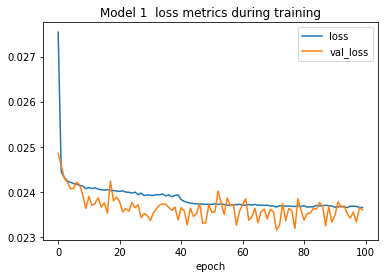

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


def plot_loss_metrics(history, model_num=None):
    for metric, values in history.items():
        sns.lineplot(x=range(len(values)), y=values, label=metric)
    plt.xlabel("epoch")
    plt.title(
        f"Model {f'{model_num} ' if model_num else ''} loss metrics during training"
    )
    plt.show()


plot_loss_metrics(history_1, "1")

Well, it didn't overfit, but this model performed a bit _worse_ than my original, which settled around a loss of 0.0231. I bet the `desc` feature is getting in the way&mdash;zeroes spanning 300 columns of the input data on 94% of the rows is probably quite confusing to the model. I'll see what happens if I repeat the process while leaving `desc` out (making the `title` vectors the only new feature of this model compared to my original).

In [22]:
history_2, _, _ = run_pipeline(
    loans.drop(columns=["fraction_recovered", "desc"]).copy(),
    loans["fraction_recovered"],
    transformer,
)

Path("save_points").mkdir(exist_ok=True)
dill.dump_session("save_points/model_2.pkl")

/opt/conda/lib/python3.7/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


[Pipeline] ....... (step 1 of 3) Processing nlp_imputer, total=   0.1s
[Pipeline] .... (step 2 of 3) Processing nlp_vectorizer, total=  41.3s
[Pipeline] ........ (step 3 of 3) Processing nlp_scaler, total=   4.6s
[ColumnTransformer] ...... (1 of 7) Processing nlp_cols, total=  45.9s
[ColumnTransformer] .... (2 of 7) Processing emp_length, total=   0.2s
[ColumnTransformer] .......... (3 of 7) Processing term, total=   0.3s
[ColumnTransformer]  (4 of 7) Processing home_ownership, total=   0.3s
[ColumnTransformer] ....... (5 of 7) Processing purpose, total=   0.3s
[ColumnTransformer]  (6 of 7) Processing application_type, total=   0.3s
[ColumnTransformer] ..... (7 of 7) Processing remainder, total=   1.1s


Training model: 100%|██████████| 100/100 [22:26<00:00, 13.46s/epoch]


Final metrics: loss: 0.02396 - val_loss: 0.02451


In [23]:
# Restore save point if needed
import dill

try:
    history_2
except NameError:
    dill.load_session("save_points/model_2.pkl")

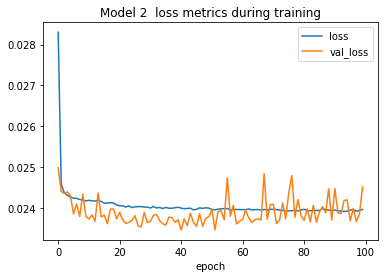

In [24]:
plot_loss_metrics(history_2, "2")

Wow, still not good enough to beat my original model. Just for kicks, I also tried additional runs where I trained for 1,000 epochs, and others where I increased the numbers of nodes in the first two dense layers to 128 and 64. And I tried decreasing the batch size to 64. But still none of these beat my original model. I suppose these text features have no predictive quality to them in terms of loan outcomes. Interesting.

## Next steps

If adding these two features decreased predictive capability, then surely removing some others would help as well. I should try using some of scikit-learn's [feature selection methods](https://scikit-learn.org/stable/modules/feature_selection.html) to reduce the dimensionality of the input data.

A more efficient method of hyperparameter optimization would be pretty useful as well. I should give [AutoKeras](https://autokeras.com/) a shot.

-----

Well that was fun! Have any thoughts on how to better integrate language data into the model? I'd love to hear them in the comments below.